# User Latent Dirichlet Allocation

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
sys.path.append(os.path.abspath('../../..')) # add the parent package to the Python path

In [2]:
%load_ext autoreload
%autoreload 2

from octis.models.LDA import LDA
from octis.models.NeuralLDA import NeuralLDA
from octis.dataset.dataset import Dataset as TextDataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

from sklearn.cluster import KMeans

from vae_playground.utils import *
from vae_playground.datasets import *
from gmm_lib import *

Import Data

In [3]:
df = pd.read_pickle('../../../data/lcl_completeYearUsers_2013.pkl')

In [4]:
RESOLUTION = 1 #in hours
num_users = df.id.nunique()
X = torch.tensor(np.array(df.consumption.to_list()), dtype=torch.float32)
X = X.reshape(num_users, 365, int(48*.5/RESOLUTION), int(RESOLUTION*2)).sum(dim=-1)
X = X[::1, ::1, :]
num_users, num_days, num_features = X.shape
X = X.flatten(end_dim=1)
print(f"Number of users: {num_users}")
print(f"Number of days: {num_days}")
print(f"Number of features: {num_features}")

Number of users: 827
Number of days: 365
Number of features: 24


In [5]:
nonzero_mean, nonzero_std = zero_preserved_log_stats(X)
X = zero_preserved_log_normalize(X, nonzero_mean, nonzero_std).reshape(num_users, num_days, num_features)
dataset = UserDayDataset(X)
X_flt = dataset.flatten_inputs
user_idx, day_idx = dataset.user_day_list[:,0], dataset.user_day_list[:,1]

In [6]:
df_plt = pd.DataFrame(torch.cat((X_flt, user_idx.unsqueeze(1), day_idx.unsqueeze(1)), dim=-1))
df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['user'] + ['day']

In [7]:
if num_users <= 100:
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='user', palette="Set1", alpha=.5)
    # move the legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='user', ncol=5)
    plt.xlabel('Morning consumption')
    plt.ylabel('Evening consumption')
    plt.show()

In [9]:
n_bins = 500
kmeans = KMeans(n_clusters=n_bins, random_state=0, n_init='auto').fit(X_flt)

In [10]:
labels = kmeans.labels_
labels_onehot = np.zeros((len(labels), len(set(labels))))
labels_onehot[np.arange(len(labels)), labels] = 1
X_words = torch.tensor(labels_onehot).reshape(num_users, num_days, -1)

In [11]:
DOC_TYPE = "day"       # "day" or "user"

if DOC_TYPE == "day":
    X_document = X_words.sum(dim=0)
elif DOC_TYPE == "user":
    X_document = X_words.sum(dim=1)
else:
    raise ValueError(f"Invalid DOC_TYPE: {DOC_TYPE}")

num_docs, num_words = X_document.shape

In [12]:
if n_bins <= 50:
    df_plt = pd.DataFrame(torch.cat((X_flt,torch.tensor(labels).unsqueeze(1)), dim=-1))
    df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['word']
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='word', palette="Set2", alpha=.5)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=100, c='black')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='word_id', ncol=5)
    plt.xlabel('Morning consumption')
    plt.ylabel('Evening consumption')
    plt.show()

In [13]:
X_labels = torch.tensor(labels).reshape(num_users, num_days)
if DOC_TYPE == "day": X_labels = X_labels.T

In [62]:
TEST_RATIO = 0.0
VAL_RATIO = 0.0

In [63]:
X_partition = ["train"]*num_docs
#change 20 percent of the users to validation set
X_partition[:int(num_docs*VAL_RATIO)] = ["val"]*int(num_docs*VAL_RATIO)
#change 20 percent of the users to test set
X_partition[int(num_docs*(1-TEST_RATIO))+1:] = ["test"]*int(num_docs*TEST_RATIO)
#randomly shuffle the partition
np.random.shuffle(X_partition)

In [64]:
#create a tsv file from X_labels and X_partition
tsv_file = open("data/corpus.tsv", "w")
for i in range(len(X_labels)):
    # tsv_file.write(' '.join([str(j.item()) for j in X_labels[i]]) + "\n")
    tsv_file.write(' '.join([str(j.item()) for j in X_labels[i]]) + "\t" + str(X_partition[i]) + "\n")
tsv_file.close()

In [65]:
##create a vocabulary.csv file
vocabulary = [str(i) for i in range(n_bins)]
#save vocabulary to a file txt
vocabulary_file = open("data/vocabulary.txt", "w")
for i in range(len(vocabulary)):
    vocabulary_file.write(vocabulary[i] + "\n")
vocabulary_file.close()

In [66]:
lda_dataset = TextDataset()
lda_dataset.load_custom_dataset_from_folder("data")

In [67]:
n_topics = 10

In [68]:
model = NeuralLDA(num_topics=n_topics, num_epochs=5000, lr=1e-4, batch_size=128, use_partitions=False, learn_priors=False)

In [69]:
# Train the model using default partitioning choice 
output = model.train_model(lda_dataset)

print(*list(output.keys()), sep="\n") # Print the output identifiers

Epoch: [1/5000]	Samples: [365/1825000]	Train Loss: 5324.84691780822	Time: 0:00:00.026882
Epoch: [2/5000]	Samples: [730/1825000]	Train Loss: 5309.592636986301	Time: 0:00:00.020300
Epoch: [3/5000]	Samples: [1095/1825000]	Train Loss: 5291.268493150685	Time: 0:00:00.019944
Epoch: [4/5000]	Samples: [1460/1825000]	Train Loss: 5328.007876712329	Time: 0:00:00.019601
Epoch: [5/5000]	Samples: [1825/1825000]	Train Loss: 5324.98852739726	Time: 0:00:00.019367
Epoch: [6/5000]	Samples: [2190/1825000]	Train Loss: 5294.510958904109	Time: 0:00:00.019569
Epoch: [7/5000]	Samples: [2555/1825000]	Train Loss: 5333.600342465754	Time: 0:00:00.019337
Epoch: [8/5000]	Samples: [2920/1825000]	Train Loss: 5285.7373287671235	Time: 0:00:00.019512
Epoch: [9/5000]	Samples: [3285/1825000]	Train Loss: 5326.544349315069	Time: 0:00:00.019562
Epoch: [10/5000]	Samples: [3650/1825000]	Train Loss: 5306.863356164384	Time: 0:00:00.021486
Epoch: [11/5000]	Samples: [4015/1825000]	Train Loss: 5354.142465753424	Time: 0:00:00.020243


In [70]:
# Initialize metric
npmi = Coherence(texts=lda_dataset.get_corpus(), topk=10, measure='c_npmi')
# Initialize metric
topic_diversity = TopicDiversity(topk=10)

In [71]:
# Retrieve metrics score
topic_diversity_score = topic_diversity.score(output)
print("Topic diversity: "+str(topic_diversity_score))

npmi_score = npmi.score(output)
print("Coherence: "+str(npmi_score))

Topic diversity: 0.64
Coherence: -0.004698508325528437


In [72]:
word_topics = torch.tensor(output["topic-word-matrix"])

<BarContainer object of 10 artists>

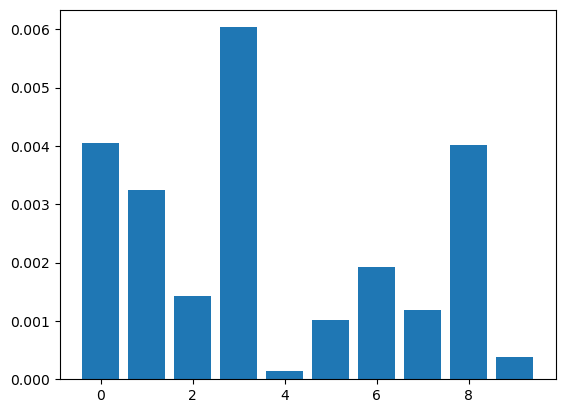

In [73]:
plt.bar(np.arange(word_topics.shape[0]),word_topics[:,1])

/home/kbolat/miniconda3/envs/torchenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


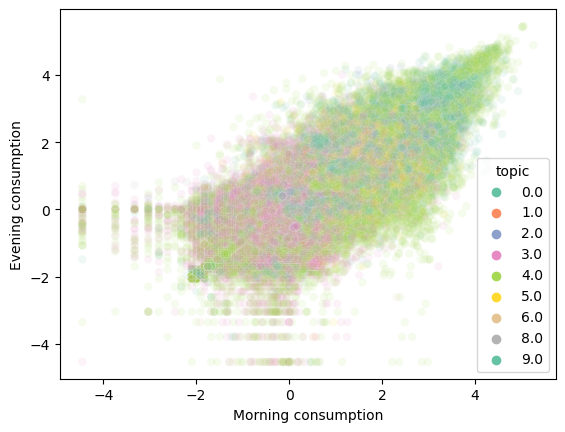

In [74]:
df_plt = pd.DataFrame(torch.cat((X_flt,(X_words.flatten(end_dim=1)@(word_topics.max(dim=0)[1].numpy())).unsqueeze(1)), dim=-1))
df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['topic']
sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='topic', palette="Set2", alpha=.1)
plt.xlabel('Morning consumption')
plt.ylabel('Evening consumption')
plt.show()

In [75]:
gamma_document = torch.tensor(output["topic-document-matrix"])

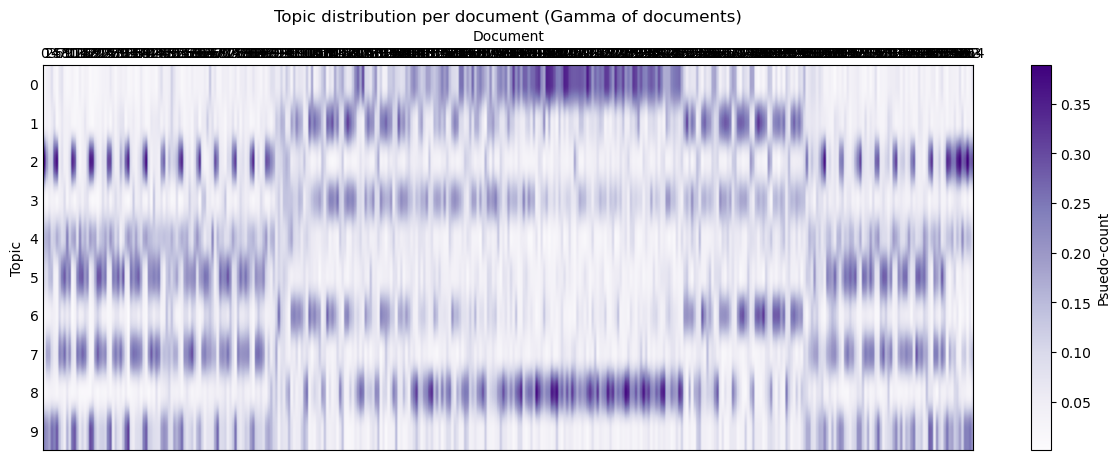

In [76]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(gamma_document, aspect='auto', cmap='Purples')
ax.set_title('Topic distribution per document (Gamma of documents)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(n_topics))
ax.set_xticks(np.arange(gamma_document.shape[1]))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Psuedo-count')
plt.show()

In [40]:
word_topics = torch.tensor(output["topic-word-matrix"])

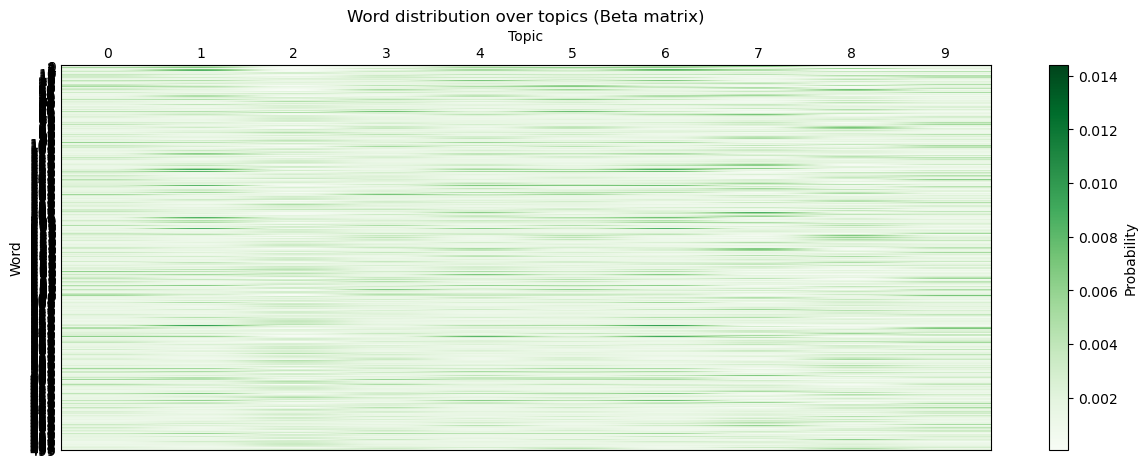

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(word_topics.T, aspect='auto', cmap='Greens')
ax.set_title('Word distribution over topics (Beta matrix)')
ax.set_xlabel('Topic')
ax.set_ylabel('Word')
ax.set_xticks(np.arange(n_topics))
ax.set_yticks(np.arange(n_bins))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Probability')
plt.show()

In [84]:
model.trained_model.eta

AttributeError: 'NeuralLDA' object has no attribute 'trained_model'